# Vehicle detection project:
The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    Estimate a bounding box for vehicles detected.


## 1. Histogram of Oriented Gradients (HOG)


In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Reading test images
images = glob.glob('test_images/*.jpg') 
orient = 9
pix_per_cell = 8
cell_per_block = 2
cnt = 0;
for img_name in images:
    img = mpimg.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    
    #plotting the test image and HOG features
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.set_title('Test Image', fontsize=40)
    ax1.imshow(img)
    ax2.imshow(hog_image, cmap = 'gray')
    ax2.set_title('HOG Visualization', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    # Scaling and saving the image
    hog_image *= 255
    out_name = 'output_images/' + img_name.split('.')[0].split('/')[-1]+'_HOG.jpg'
    cv2.imwrite(out_name,hog_image)
    
    

## 2. Trainning the classifier

In [ ]:
import os
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

# Function to compute the spatial 
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Function to compution the hitogram of the color channels
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# extracting features function
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        all_features = np.hstack((spatial_features, hist_features, hog_features))
        features.append(all_features)
        
    # Return list of feature vectors
    return features

# Divide up into cars and notcars

# Reading the vehicles from the image database
vehicles = []
drts = os.listdir('vehicles/vehicles/')
for drt in drts:
    vehicles.append(glob.glob('vehicles/vehicles/'+drt+'/*.png'))
vehicles = sum(vehicles, [])

# Reading the non-vehicles from the image database
n_vehicles = []
drts = os.listdir('non-vehicles/non-vehicles/')
for drt in drts:
    n_vehicles.append(glob.glob('non-vehicles/non-vehicles/'+drt+'/*.png'))
n_vehicles = sum(n_vehicles, [])

print('The database contains', len(vehicles), ' vehicles')
print('The database contains', len(n_vehicles), ' non-vehicles')


# Reduce the sample size because HOG features are slow to compute
sample_size = 5000
cars = vehicles#[0:sample_size]
notcars = n_vehicles#[0:sample_size]

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 16

t=time.time()
                     
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler(copy = False).fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

## Sliding window search

In [ ]:
def convert_color(img, conv='RGB2HSV'):
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features



def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_list.append(box)
                cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 

    return draw_img, box_list




spatial_size = (16, 16)
hist_bins = 16
ystart = 400
ystop = 656
scale = 1.5

images = glob.glob('test_images/*.jpg')
for img_name in images:
    img = mpimg.imread(img_name)
    out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.imshow(out_img)
    plt.show()


## Multiple search and False positves

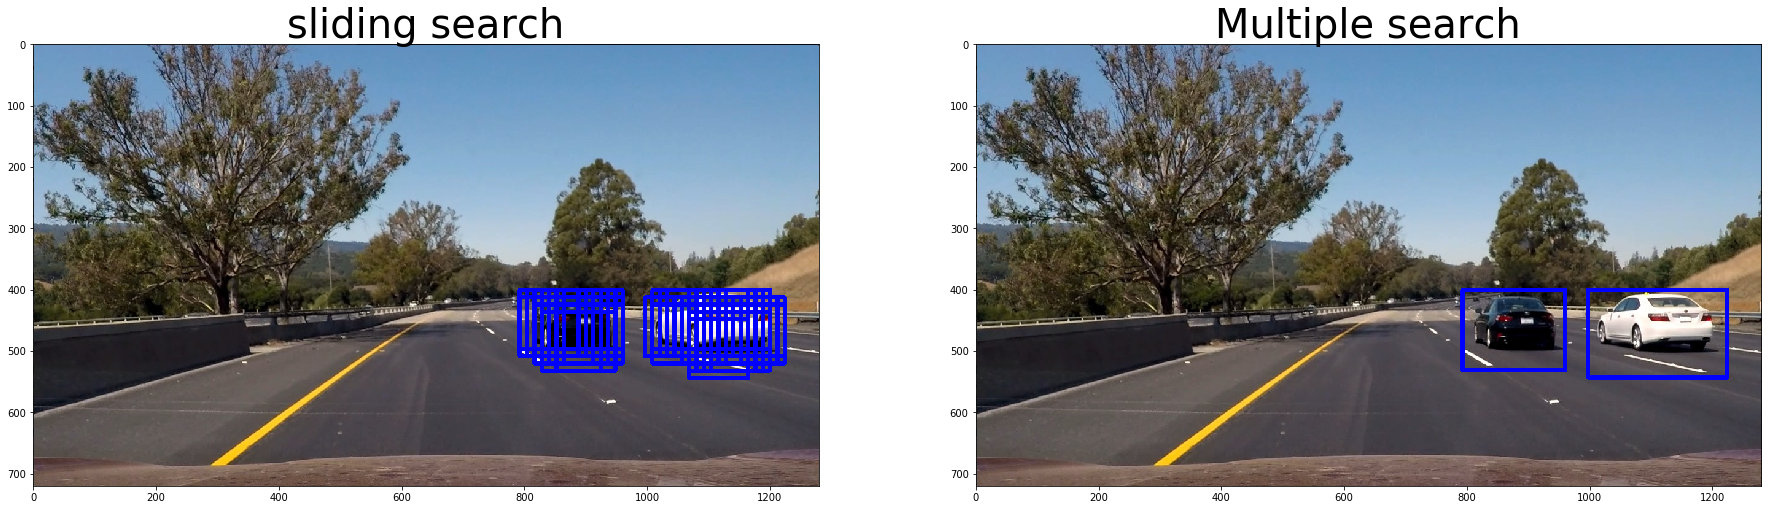

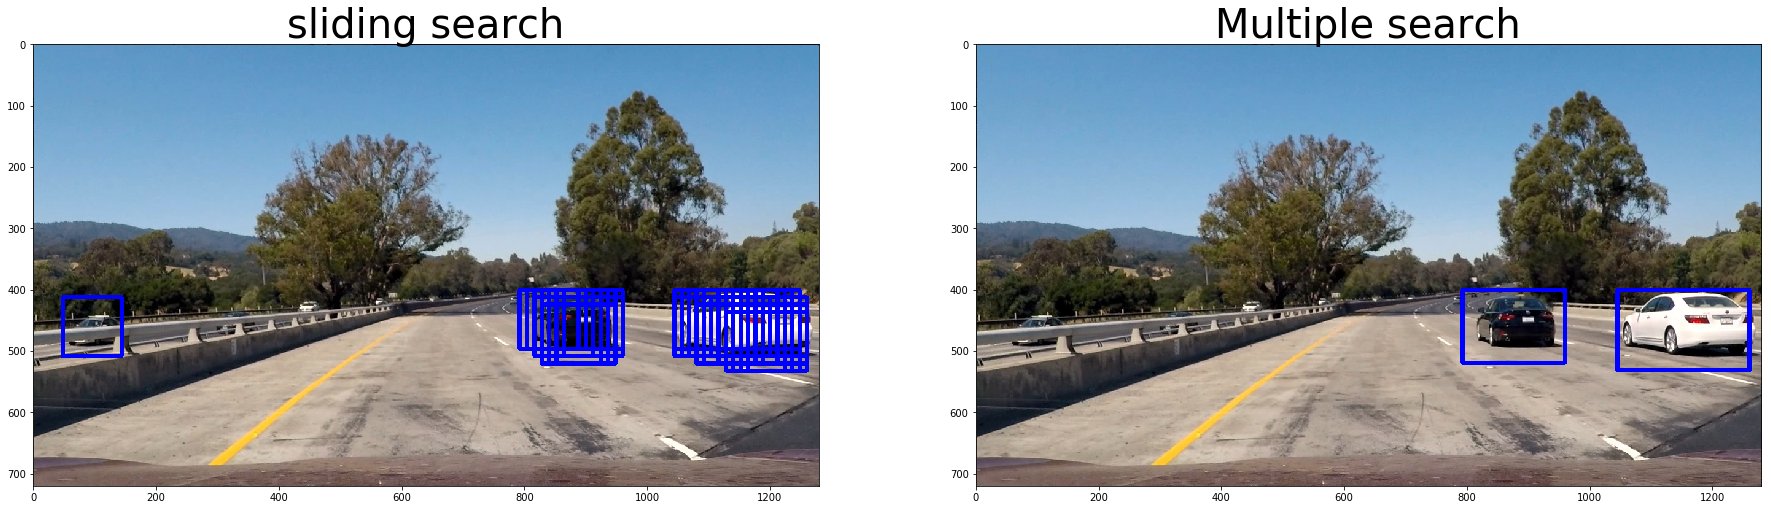

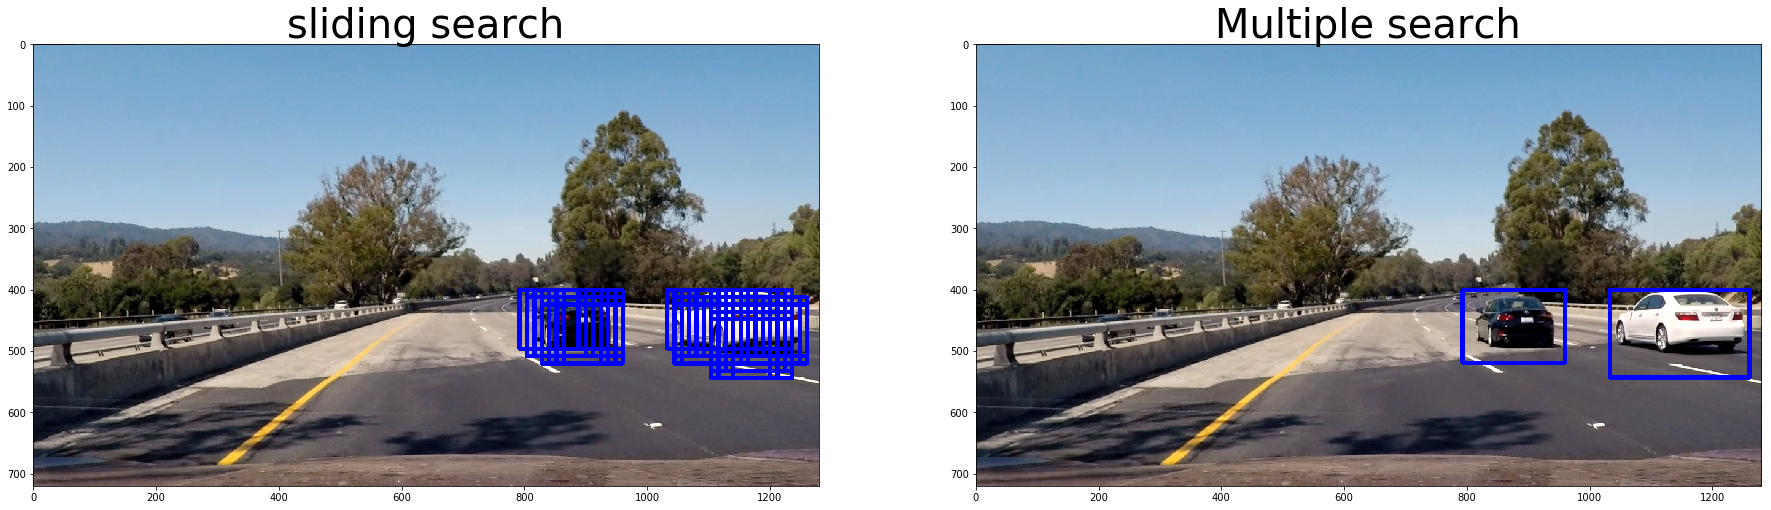

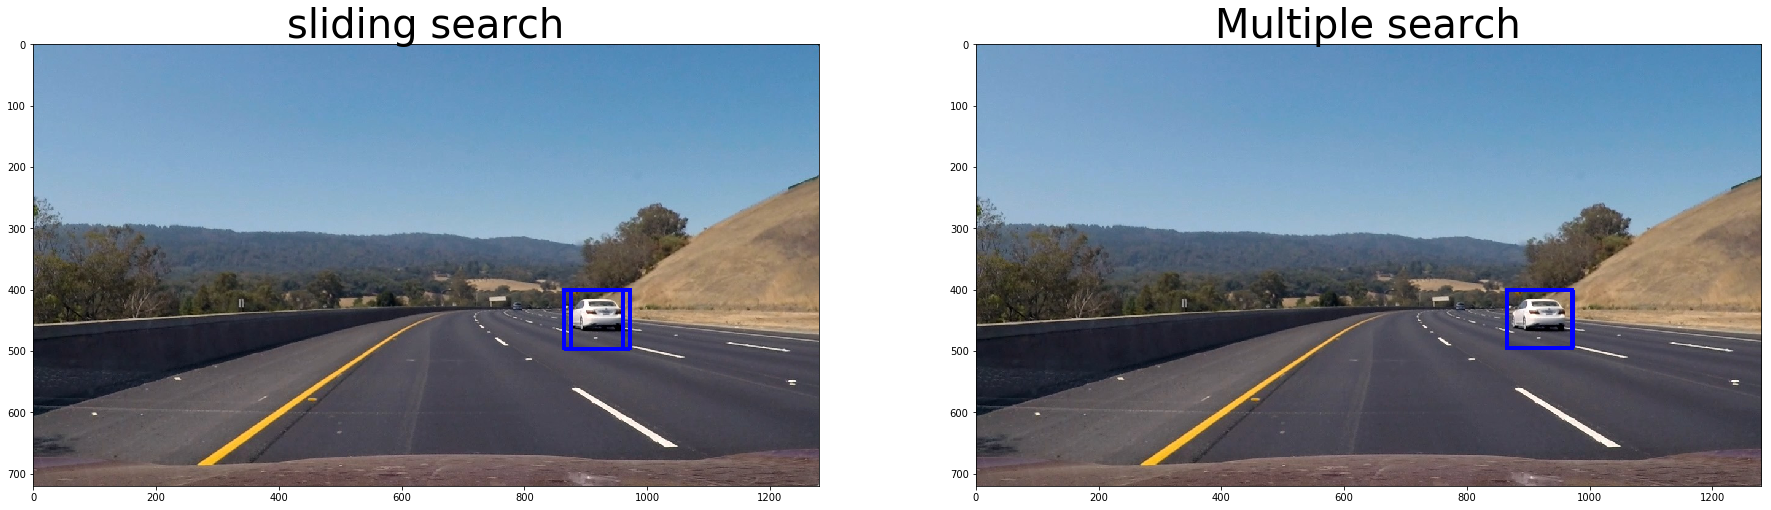

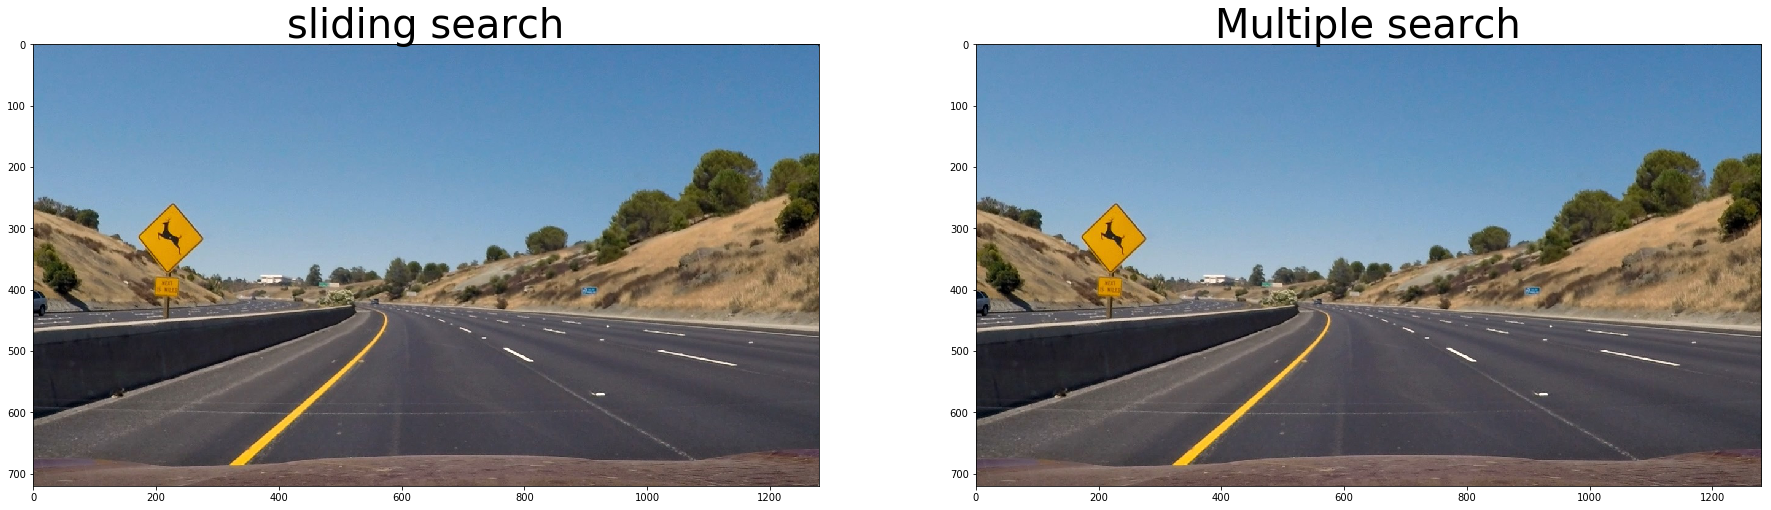

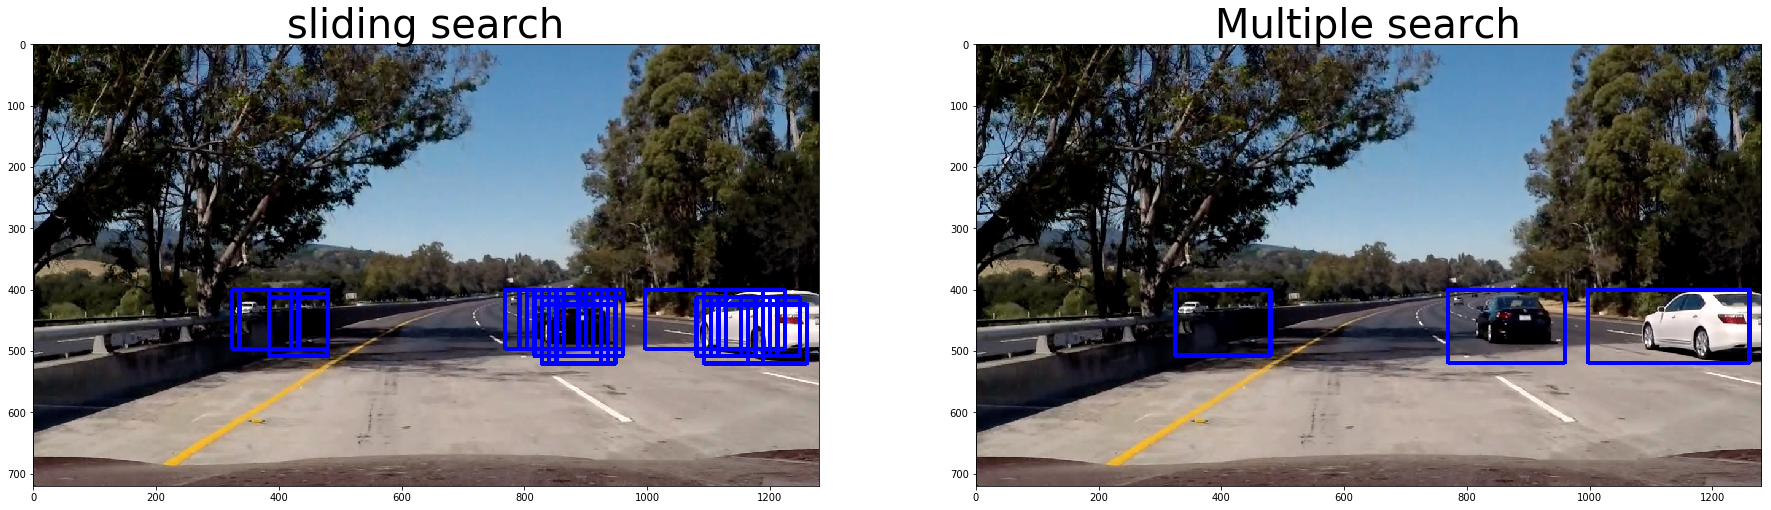

In [68]:
from scipy.ndimage.measurements import label


# Function to add compute the heat map of the image
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for  box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    for box in bbox_list:
        if (np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > 1):
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Function to apply the threshold on the heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# This function allows drawing the boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Reading test images names
images = glob.glob('test_images/*.jpg')
for img_name in images:
    # Reading the image
    img = mpimg.imread(img_name)
    
    #sliding window search
    out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Drawing the images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.set_title('sliding search', fontsize=40)
    ax1.imshow(out_img)
    ax2.imshow(draw_img)
    ax2.set_title('Multiple search', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


## Vehicle detection pipeline on video stream

In [ ]:
def detection_pipiline(img):
    global start, box_list1, box_list2
    #sliding window search
    
    out_img, box_listl = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    if(start == 1):
        box_list1 = [box_listl]
        box_list2 = box_listl
        
        
    start = 0;
    
    heat = add_heat(heat,box_list2)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,12)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # drawing the boxes on the images
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    if start !=1:
        box_list1.append(box_listl)
        if(len(box_list1) == 15):
            box_list1 = box_list1[0:13]
            box_list1.append(box_listl)
        box_list2 = []
        for b in box_list1:
            box_list2.extend(b)
      
    return draw_img
    
start = 1
box_list1=[]
from moviepy.editor import VideoFileClip
test_output = 'test_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
output_clip = clip1.fl_image(detection_pipiline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(test_output, audio=False)




[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4

































  0%|          | 0/39 [00:00<?, ?it/s]






























  3%|▎         | 1/39 [00:01<01:04,  1.70s/it]






























  5%|▌         | 2/39 [00:03<01:04,  1.75s/it]






























  8%|▊         | 3/39 [00:05<01:02,  1.74s/it]






























 10%|█         | 4/39 [00:07<01:01,  1.76s/it]






























 13%|█▎        | 5/39 [00:08<00:57,  1.70s/it]






























 15%|█▌        | 6/39 [00:10<00:54,  1.65s/it]






























 18%|█▊        | 7/39 [00:11<00:51,  1.61s/it]






























 21%|██        | 8/39 [00:13<00:49,  1.60s/it]






























 23%|██▎       | 9/39 [00:15<00:49,  1.64s/it]






























 26%|██▌       | 10/39 [00:16<00:47,  1.65s/it]






























 28%|██▊       | 11/39 [00:18<00:45,  1.62s/it]






























 31%|███       | 12/39 [00:19<00:43,  1.63s/it]





## Project video

In [79]:
test_output = 'project_output.mp4'
start = 1
box_list1=[]
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(detection_pipiline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4

































  0%|          | 0/1261 [00:00<?, ?it/s]






























  0%|          | 1/1261 [00:01<39:59,  1.90s/it]






























  0%|          | 2/1261 [00:03<40:02,  1.91s/it]






























  0%|          | 3/1261 [00:05<39:11,  1.87s/it]






























  0%|          | 4/1261 [00:07<37:52,  1.81s/it]






























  0%|          | 5/1261 [00:08<36:53,  1.76s/it]






























  0%|          | 6/1261 [00:10<36:19,  1.74s/it]






























  1%|          | 7/1261 [00:12<36:05,  1.73s/it]






























  1%|          | 8/1261 [00:13<35:24,  1.70s/it]






























  1%|          | 9/1261 [00:15<35:24,  1.70s/it]






























  1%|          | 10/1261 [00:17<35:11,  1.69s/it]






























  1%|          | 11/1261 [00:18<35:13,  1.69s/it]






























  1%|          | 12/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 33min 4s, sys: 10.5 s, total: 33min 15s
Wall time: 32min 58s
